In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
Device Name: NVIDIA GeForce RTX 3080 Laptop GPU


# Загрузка датасета

In [2]:
import pandas as pd

df = pd.read_csv('dataset/amazon_reviews_small.csv')
df = df[['category','reviewText', 'class']]

The class label is spam and not spam, where "0" indicates not spam and "1" indicates spam reviews

In [3]:
df[df['class'] == 1].shape

(661017, 3)

In [4]:
df[df['class'] == 0].shape

(661017, 3)

In [5]:
df.head()

,category,reviewText,class
0,Clothing_Shoes_and_Jewelry,I really LOVE these shoes. I can't take them o...,1
1,Electronics,I have purchased this item 3 times as it makes...,1
2,Clothing_Shoes_and_Jewelry,Don't wear this every day! It is a bit flimsy...,1
3,Sports_and_Outdoors,It was the largest one I could haul into an up...,1
4,Sports_and_Outdoors,I liked this product. They are easy to adjust...,1


Будет использоваться набор данных по 1000 на каждый класс.


In [6]:
from sklearn.utils import shuffle

df_class_0 = df[df['class'] == 0].sample(n=1000, random_state=42)
df_class_1 = df[df['class'] == 1].sample(n=1000, random_state=42)
df = pd.concat([df_class_0, df_class_1])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = shuffle(df).reset_index(drop=True)

In [7]:
df['category'].value_counts()

category
Cell_Phones_and_Accessories    389
Electronics                    364
Clothing_Shoes_and_Jewelry     329
Home_and_Kitchen               325
Sports_and_Outdoors            312
Toys_and_Games                 281
Name: count, dtype: int64

# Предобработка

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")
stemmer = SnowballStemmer('english')
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

def preprocess_text(text, use_stopword_punctuation_delete=True, use_stemming=True, use_lemmatization=True):
    text = text.lower()
    words = text.split()
    if use_stopword_punctuation_delete:
        text = ''.join([char for char in text if char not in string.punctuation])
        words = text.split()
        words = [word for word in words if word not in nltk_stopwords and word not in STOP_WORDS]
    if use_lemmatization:
        doc = nlp(" ".join(words))
        words = [token.lemma_ for token in doc]
    if use_stemming:
        words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package stopwords to C:\Users\MSI
[nltk_data]     GS66\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Обучение модели

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, TrainerCallback
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.val_losses.append(logs['eval_loss'])

    def get_losses(self):
        return self.train_losses, self.val_losses

def train_model(dataset, tokenizer, model_name='distilbert-base-uncased', batch_size=512, epochs=10, max_length=256):
    train_texts, val_texts, train_labels, val_labels = train_test_split(dataset['reviewText'], dataset['class'], test_size=0.2)

    train_texts = train_texts.reset_index(drop=True)
    val_texts = val_texts.reset_index(drop=True)
    train_labels = train_labels.reset_index(drop=True)
    val_labels = val_labels.reset_index(drop=True)

    train_dataset = SpamDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = SpamDataset(val_texts, val_labels, tokenizer, max_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    model.config.attention_probs_dropout_prob = 0.5
    model.config.hidden_dropout_prob = 0.5
    for param in model.distilbert.parameters():
        param.requires_grad = False
    for param in model.distilbert.transвывыфвыфвфвы.parameters():
        param.requires_grad = True

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_strategy="epoch",
        save_total_limit=2,
        weight_decay=0.01
    )

    loss_logging_callback = LossLoggingCallback()
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        callbacks=[loss_logging_callback]
    )

    trainer.train()

    predictions, labels, metrics = trainer.predict(val_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    accuracy = accuracy_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1 Score'],
    'Score': [precision, recall, accuracy, f1]
    })
    table = tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', showindex=False)
    print(table)

    conf_matrix = confusion_matrix(labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    train_losses, val_losses = loss_logging_callback.get_losses()
    print(train_losses)
    print(val_losses)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

## Без предобработки

In [14]:
torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.669900,0.604333
2,0.521200,0.391882
3,0.382700,0.314762
4,0.311100,0.306179
5,0.275000,0.298390
6,0.246300,0.293849
7,0.224300,0.295744
8,0.210000,0.300294
9,0.202200,0.303178
10,0.199300,0.303322


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.884615 │
├───────────┼──────────┤
│ Recall    │ 0.880383 │
├───────────┼──────────┤
│ Accuracy  │ 0.8775   │
├───────────┼──────────┤
│ F1 Score  │ 0.882494 │
╘═══════════╧══════════╛


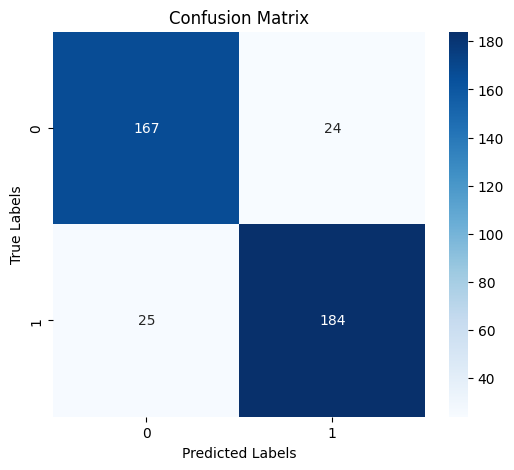

[0.6699, 0.5212, 0.3827, 0.3111, 0.275, 0.2463, 0.2243, 0.21, 0.2022, 0.1993]
[0.604332685470581, 0.39188194274902344, 0.3147616684436798, 0.30617934465408325, 0.2983904182910919, 0.2938493490219116, 0.2957439124584198, 0.30029377341270447, 0.3031781017780304, 0.3033222258090973]


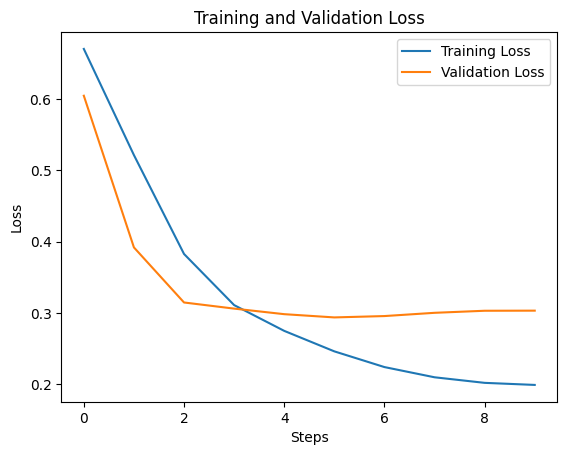

In [15]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df, tokenizer)

## Удаление стоп-слов и пунктуации

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.682200,0.651830
2,0.637300,0.569602
3,0.560300,0.491570
4,0.488500,0.451650
5,0.453000,0.428579
6,0.416800,0.448021
7,0.395800,0.421811
8,0.376800,0.420503
9,0.370000,0.422355
10,0.360000,0.421910


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.794872 │
├───────────┼──────────┤
│ Recall    │ 0.775    │
├───────────┼──────────┤
│ Accuracy  │ 0.7875   │
├───────────┼──────────┤
│ F1 Score  │ 0.78481  │
╘═══════════╧══════════╛


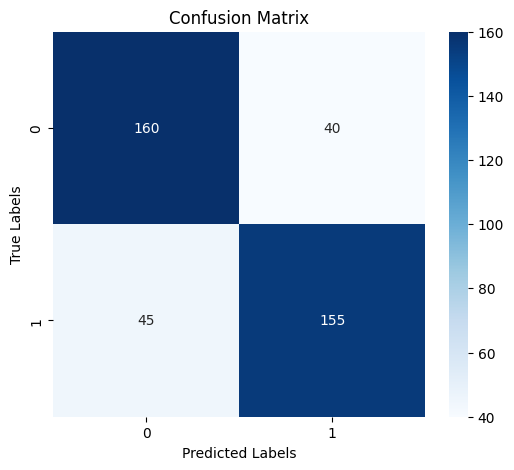

[0.6822, 0.6373, 0.5603, 0.4885, 0.453, 0.4168, 0.3958, 0.3768, 0.37, 0.36]
[0.6518303155899048, 0.5696019530296326, 0.49156975746154785, 0.4516496956348419, 0.4285792410373688, 0.4480213224887848, 0.4218108355998993, 0.420502632856369, 0.4223552346229553, 0.4219104051589966]


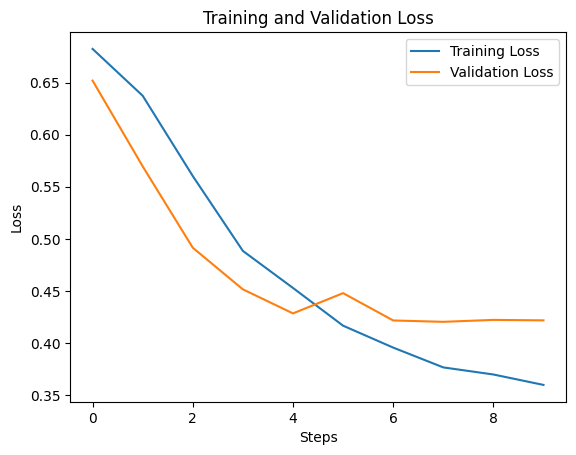

In [16]:
df_use_stopword_punctuation_delete = df.copy()
df_use_stopword_punctuation_delete['reviewText'] = df_use_stopword_punctuation_delete['reviewText'].apply(
                    lambda x: preprocess_text(x, True, False, False)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stopword_punctuation_delete, tokenizer)

## Удаление стоп-слов и пунктуации + стемминг

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.686900,0.667462
2,0.658900,0.617586
3,0.611700,0.575265
4,0.554300,0.537697
5,0.521700,0.510377
6,0.483900,0.525276
7,0.468300,0.501681
8,0.437100,0.499165
9,0.427000,0.495815
10,0.417900,0.495054


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.752525 │
├───────────┼──────────┤
│ Recall    │ 0.745    │
├───────────┼──────────┤
│ Accuracy  │ 0.75     │
├───────────┼──────────┤
│ F1 Score  │ 0.748744 │
╘═══════════╧══════════╛


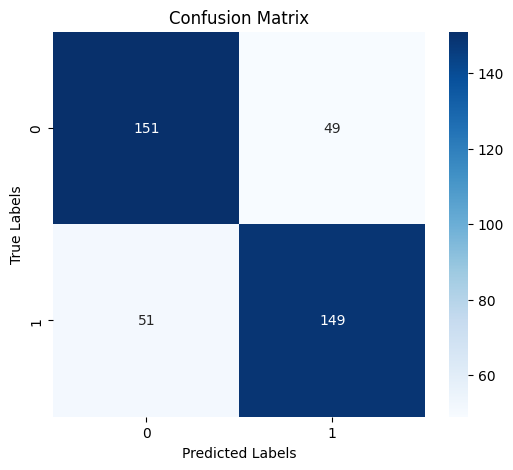

[0.6869, 0.6589, 0.6117, 0.5543, 0.5217, 0.4839, 0.4683, 0.4371, 0.427, 0.4179]
[0.6674622297286987, 0.6175856590270996, 0.575264573097229, 0.5376966595649719, 0.5103772878646851, 0.5252758860588074, 0.5016807317733765, 0.49916496872901917, 0.4958147704601288, 0.49505355954170227]


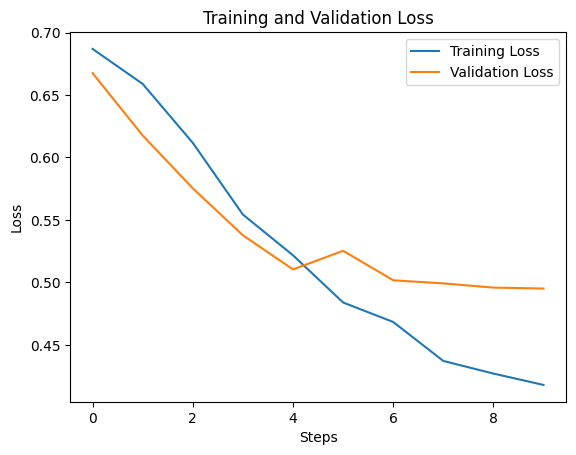

In [17]:
df_use_stopword_punctuation_delete_stemming = df.copy()
df_use_stopword_punctuation_delete_stemming['reviewText'] = df_use_stopword_punctuation_delete_stemming['reviewText'].apply(
                    lambda x: preprocess_text(x, True, True, False)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stopword_punctuation_delete_stemming, tokenizer)

## Удаление стоп-слов и пунктуации + стемминг + лемматизация

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.687300,0.667961
2,0.661100,0.621219
3,0.616200,0.579111
4,0.559900,0.542403
5,0.525400,0.516453
6,0.487200,0.531197
7,0.467700,0.508344
8,0.436400,0.508372
9,0.428500,0.503868
10,0.420700,0.502893


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Precision │    0.74 │
├───────────┼─────────┤
│ Recall    │    0.74 │
├───────────┼─────────┤
│ Accuracy  │    0.74 │
├───────────┼─────────┤
│ F1 Score  │    0.74 │
╘═══════════╧═════════╛


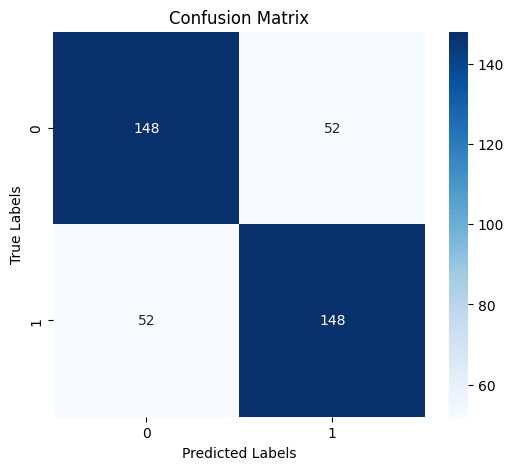

[0.6873, 0.6611, 0.6162, 0.5599, 0.5254, 0.4872, 0.4677, 0.4364, 0.4285, 0.4207]
[0.6679612994194031, 0.621218740940094, 0.5791105031967163, 0.5424029231071472, 0.5164533853530884, 0.5311970114707947, 0.5083440542221069, 0.5083723664283752, 0.5038682222366333, 0.5028929710388184]


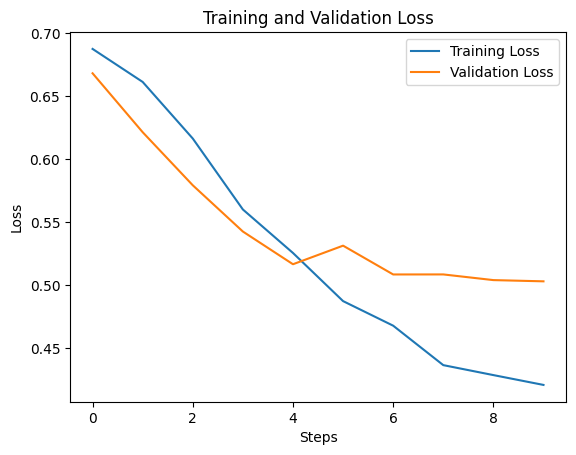

In [18]:
df_use_stopword_punctuation_delete_stemming_lemmatization = df.copy()
df_use_stopword_punctuation_delete_stemming_lemmatization['reviewText'] = df_use_stopword_punctuation_delete_stemming_lemmatization['reviewText'].apply(
                    lambda x: preprocess_text(x, True, True, True)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stopword_punctuation_delete_stemming_lemmatization, tokenizer)

## Удаление стоп-слов и пунктуации + лемматизация

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.683700,0.657356
2,0.649300,0.588015
3,0.581600,0.520169
4,0.513000,0.475207
5,0.477300,0.448995
6,0.435700,0.457966
7,0.414300,0.437363
8,0.401900,0.440704
9,0.386700,0.438162
10,0.378500,0.435845


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.824742 │
├───────────┼──────────┤
│ Recall    │ 0.8      │
├───────────┼──────────┤
│ Accuracy  │ 0.815    │
├───────────┼──────────┤
│ F1 Score  │ 0.812183 │
╘═══════════╧══════════╛


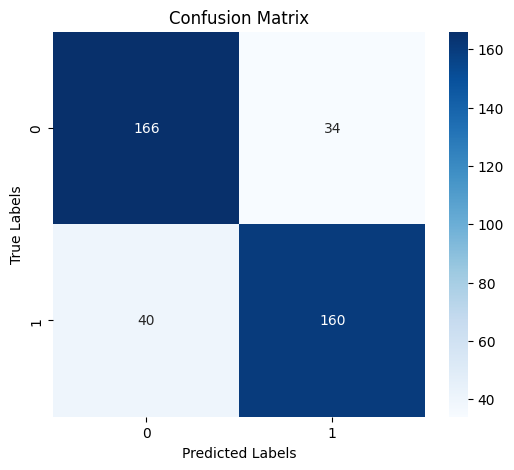

[0.6837, 0.6493, 0.5816, 0.513, 0.4773, 0.4357, 0.4143, 0.4019, 0.3867, 0.3785]
[0.6573562026023865, 0.588014543056488, 0.5201687812805176, 0.47520655393600464, 0.4489946663379669, 0.4579662084579468, 0.43736305832862854, 0.4407036602497101, 0.4381623864173889, 0.4358454644680023]


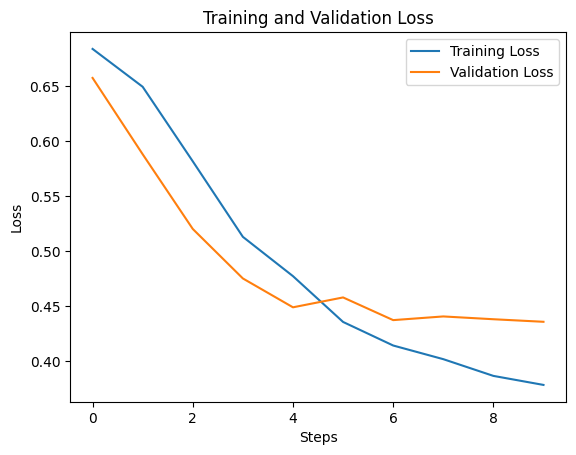

In [19]:
df_use_stopword_punctuation_delete_lemmatization = df.copy()
df_use_stopword_punctuation_delete_lemmatization['reviewText'] = df_use_stopword_punctuation_delete_lemmatization['reviewText'].apply(
                    lambda x: preprocess_text(x, True, False, True)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stopword_punctuation_delete_lemmatization, tokenizer)

## Стемминг

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.681400,0.648040
2,0.614700,0.493834
3,0.472800,0.367455
4,0.390700,0.344944
5,0.340900,0.342366
6,0.316100,0.338683
7,0.289300,0.329556
8,0.274600,0.327698
9,0.271100,0.326796
10,0.260000,0.328075


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.852941 │
├───────────┼──────────┤
│ Recall    │ 0.87     │
├───────────┼──────────┤
│ Accuracy  │ 0.86     │
├───────────┼──────────┤
│ F1 Score  │ 0.861386 │
╘═══════════╧══════════╛


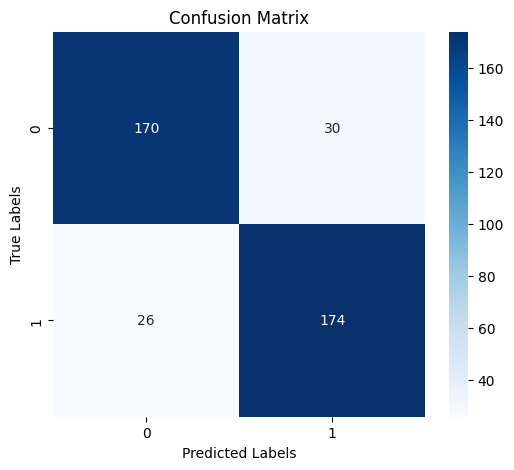

[0.6814, 0.6147, 0.4728, 0.3907, 0.3409, 0.3161, 0.2893, 0.2746, 0.2711, 0.26]
[0.6480401754379272, 0.4938337802886963, 0.36745479702949524, 0.34494397044181824, 0.3423658013343811, 0.3386828601360321, 0.3295559287071228, 0.3276982009410858, 0.3267960846424103, 0.3280748724937439]


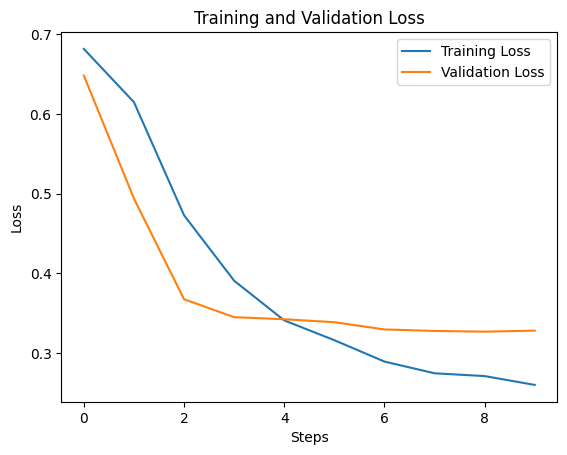

In [20]:
df_use_stemming = df.copy()
df_use_stemming['reviewText'] = df_use_stemming['reviewText'].apply(
                    lambda x: preprocess_text(x, False, True, False)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stemming, tokenizer)

## Стемминг + лемматизация

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.684700,0.657370
2,0.631200,0.524912
3,0.505000,0.389432
4,0.414900,0.355995
5,0.370400,0.328473
6,0.337000,0.315994
7,0.312900,0.302911
8,0.295200,0.298188
9,0.288500,0.297193
10,0.279700,0.299821


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.847619 │
├───────────┼──────────┤
│ Recall    │ 0.89     │
├───────────┼──────────┤
│ Accuracy  │ 0.865    │
├───────────┼──────────┤
│ F1 Score  │ 0.868293 │
╘═══════════╧══════════╛


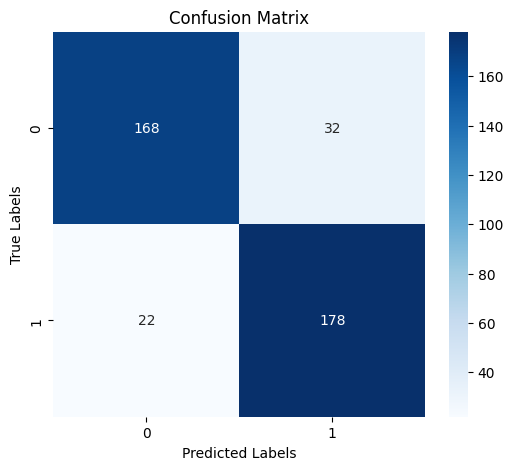

[0.6847, 0.6312, 0.505, 0.4149, 0.3704, 0.337, 0.3129, 0.2952, 0.2885, 0.2797]
[0.65736985206604, 0.5249119997024536, 0.38943246006965637, 0.3559945225715637, 0.32847312092781067, 0.31599411368370056, 0.3029109835624695, 0.2981875538825989, 0.2971925437450409, 0.29982060194015503]


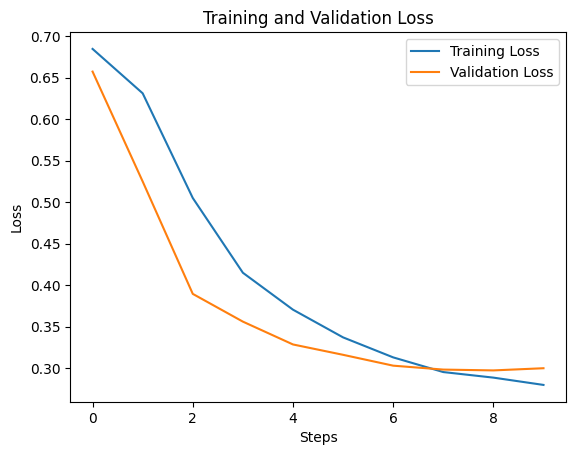

In [21]:
df_use_stemming_lemmatization = df.copy()
df_use_stemming_lemmatization['reviewText'] = df_use_stemming_lemmatization['reviewText'].apply(
                    lambda x: preprocess_text(x, False, True, True)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_stemming_lemmatization, tokenizer)

## Лемматизация

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss
1,0.679400,0.636470
2,0.589400,0.440903
3,0.436600,0.318183
4,0.364800,0.290558
5,0.333100,0.295352
6,0.297800,0.289175
7,0.282200,0.272859
8,0.273700,0.269109
9,0.259600,0.271406
10,0.250800,0.270322


╒═══════════╤═════════╕
│ Metric    │   Score │
╞═══════════╪═════════╡
│ Precision │   0.875 │
├───────────┼─────────┤
│ Recall    │   0.875 │
├───────────┼─────────┤
│ Accuracy  │   0.875 │
├───────────┼─────────┤
│ F1 Score  │   0.875 │
╘═══════════╧═════════╛


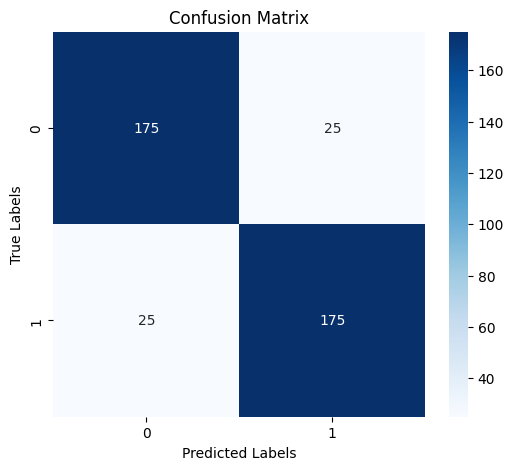

[0.6794, 0.5894, 0.4366, 0.3648, 0.3331, 0.2978, 0.2822, 0.2737, 0.2596, 0.2508]
[0.6364697813987732, 0.4409025311470032, 0.31818312406539917, 0.2905580997467041, 0.29535162448883057, 0.289175420999527, 0.2728586494922638, 0.26910942792892456, 0.27140557765960693, 0.2703222632408142]


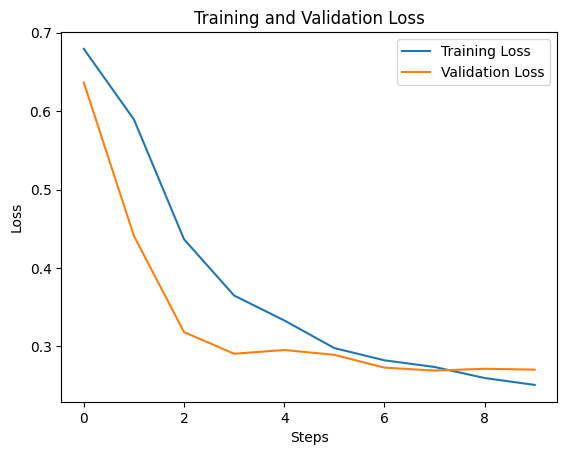

In [22]:
df_use_lemmatization = df.copy()
df_use_lemmatization['reviewText'] = df_use_lemmatization['reviewText'].apply(
                    lambda x: preprocess_text(x, False, False, True)
                )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_model(df_use_lemmatization, tokenizer)

## Без предобработки и без приведения к нижнему регистру

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI GS66\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\MSI GS66\AppData\Local\Temp\ipykernel_13564\3188242045.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` in

Epoch,Training Loss,Validation Loss
1,0.689000,0.672483
2,0.648100,0.568154
3,0.505700,0.391516
4,0.389200,0.359208
5,0.341400,0.334740
6,0.298500,0.328104
7,0.271100,0.332995
8,0.254100,0.328603
9,0.248700,0.327906
10,0.236400,0.328224


╒═══════════╤══════════╕
│ Metric    │    Score │
╞═══════════╪══════════╡
│ Precision │ 0.882979 │
├───────────┼──────────┤
│ Recall    │ 0.83     │
├───────────┼──────────┤
│ Accuracy  │ 0.86     │
├───────────┼──────────┤
│ F1 Score  │ 0.85567  │
╘═══════════╧══════════╛


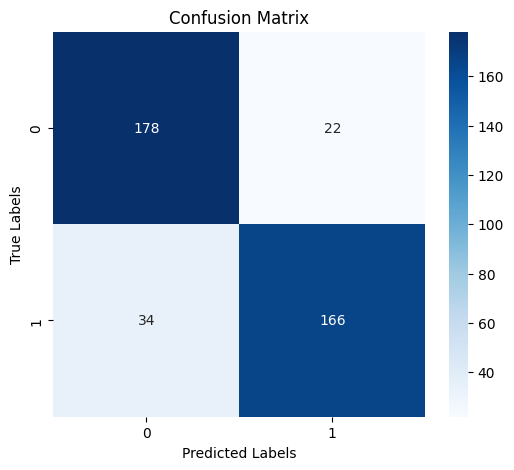

[0.689, 0.6481, 0.5057, 0.3892, 0.3414, 0.2985, 0.2711, 0.2541, 0.2487, 0.2364]
[0.6724829077720642, 0.5681544542312622, 0.39151623845100403, 0.3592075705528259, 0.3347400724887848, 0.32810378074645996, 0.3329951763153076, 0.3286026418209076, 0.32790619134902954, 0.32822391390800476]


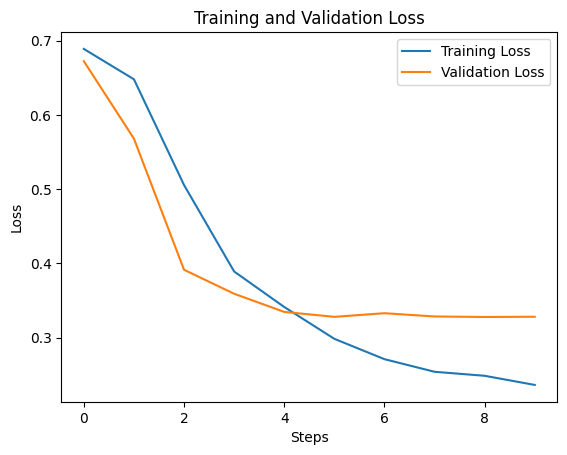

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
train_model(df, tokenizer, model_name='distilbert-base-cased')